# Ejercicio Data Augmentation

En este ejercicio se utilizará el dataset de manos, en el cual hay imágenes de 64x64 pixeles a color divididas en 6 clases, cada una representando un número distinto (0, 1, 2, 3, 4 o 5) indicado con los dedos de la mano.

El conjunto de entrenamiento fue modificado de forma tal que el mismo sobreentrene una red neuronal convolucional si no se aplica ningún tipo de data augmentation. Dentro de la carpeta `train/` se encuentran 6 carpetas, cada una con 30 imágenes. El conjunto de validación no fue modificado. El mismo se encuentra en la carpeta `valid/` con 20 imágenes en cada clase.

El objetivo de este ejercicio es, entonces, realizar entrenamientos de una misma arquitectura de red convolucional, utilizando data augmentation para obtener la mejor performance posible.

In [91]:
import os, random, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch, torchvision, torchmetrics, torchsummary
import torch.nn as nn
import torch.optim as optim

In [92]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando MPS (Apple GPU)


### Visualización de los datos

Con la siguiente celda de código podemos visualizar una imagen de cada clase, tomada al azar, del conjunto de entrenamiento. Siempre es importante tener nocion de como lucen las imágenes de nuestro set de datos, tanto de entrenamiento como validación. Esto nos ayudará a saber que tipos de transformaciones serán más útiles cuando realicemos data augmentation.

In [93]:
ROOT_PATH = os.getcwd()
TRAIN_PATH = ROOT_PATH + "/dataset/hands/train/"
TEST_PATH = ROOT_PATH + "/dataset/hands/valid/"

# Train sets
CLASS_0_TRAIN_PATH = TRAIN_PATH + "0/"
CLASS_1_TRAIN_PATH = TRAIN_PATH + "1/"
CLASS_2_TRAIN_PATH = TRAIN_PATH + "2/"
CLASS_3_TRAIN_PATH = TRAIN_PATH + "3/"
CLASS_4_TRAIN_PATH = TRAIN_PATH + "4/"
CLASS_5_TRAIN_PATH = TRAIN_PATH + "5/"

# Test sets
CLASS_0_TEST_PATH = TEST_PATH + "0/"
CLASS_1_TEST_PATH = TEST_PATH + "1/"
CLASS_2_TEST_PATH = TEST_PATH + "2/"
CLASS_3_TEST_PATH = TEST_PATH + "3/"
CLASS_4_TEST_PATH = TEST_PATH + "4/"
CLASS_5_TEST_PATH = TEST_PATH + "5/"

In [94]:
# How many images per class (train + test)?
train_paths = [CLASS_0_TRAIN_PATH, CLASS_1_TRAIN_PATH, CLASS_2_TRAIN_PATH, CLASS_3_TRAIN_PATH, CLASS_4_TRAIN_PATH, CLASS_5_TRAIN_PATH]
test_paths = [CLASS_0_TEST_PATH, CLASS_1_TEST_PATH, CLASS_2_TEST_PATH, CLASS_3_TEST_PATH, CLASS_4_TEST_PATH, CLASS_5_TEST_PATH]
train_images = 0
test_images = 0
for path in train_paths:
    train_images += len(os.listdir(path))
for path in test_paths:
    test_images += len(os.listdir(path))
print(f"Train images: {train_images}, Test images: {test_images}")

Train images: 120, Test images: 120


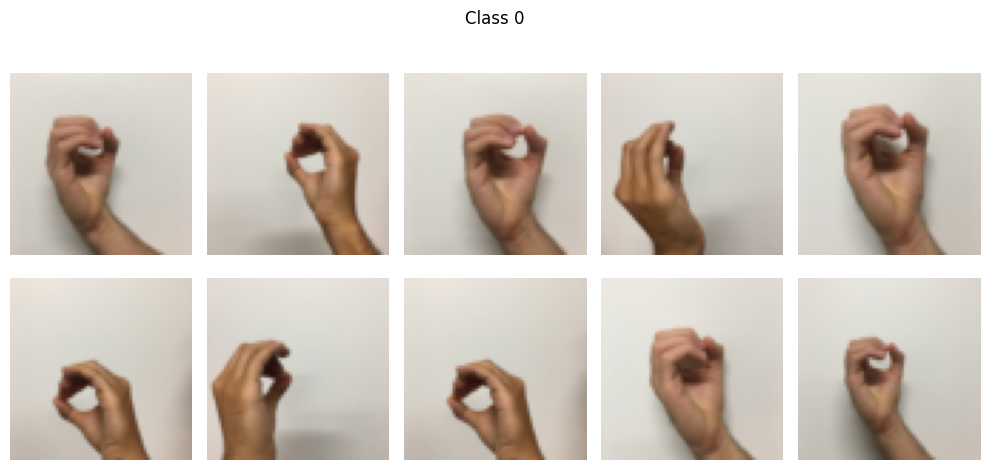

In [95]:
# Plot 10 random hands from the class 0
files = os.listdir(CLASS_0_TRAIN_PATH)
random_files = random.sample(files, 10)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for id, file in enumerate(random_files):
    axs[id//5, id%5].imshow(mpimg.imread(CLASS_0_TRAIN_PATH + file))
    axs[id//5, id%5].axis('off')
plt.suptitle("Class 0")
plt.tight_layout()
plt.show()

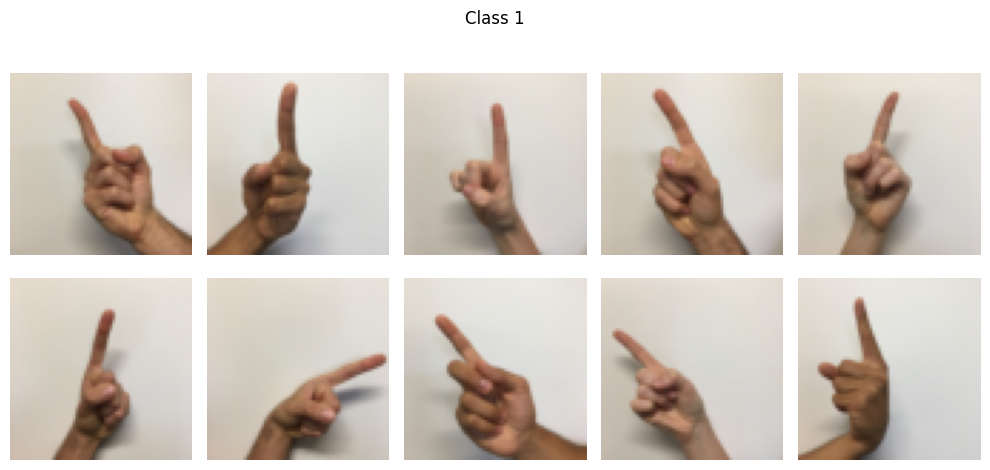

In [96]:
# Plot 10 random hands from the class 1
files = os.listdir(CLASS_1_TRAIN_PATH)
random_files = random.sample(files, 10)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for id, file in enumerate(random_files):
    axs[id//5, id%5].imshow(mpimg.imread(CLASS_1_TRAIN_PATH + file))
    axs[id//5, id%5].axis('off')
plt.suptitle("Class 1")
plt.tight_layout()
plt.show()

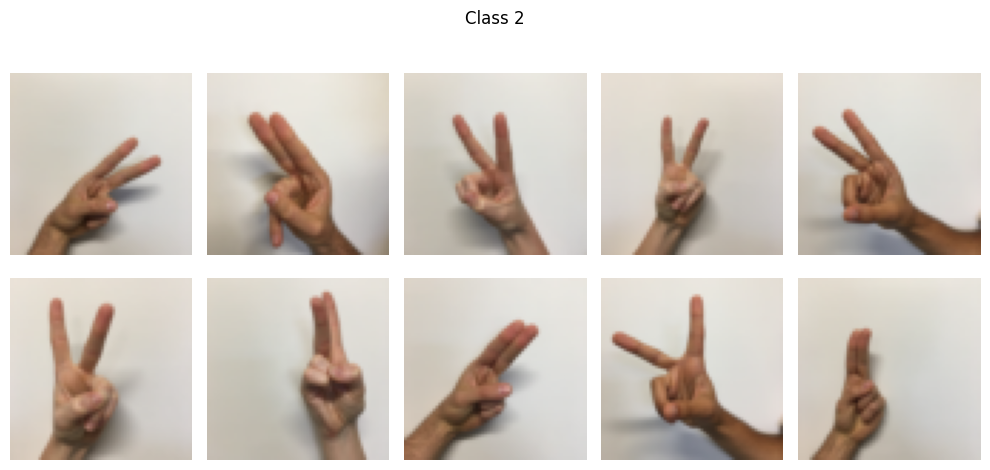

In [97]:
# Plot 10 random hands from the class 2
files = os.listdir(CLASS_2_TRAIN_PATH)
random_files = random.sample(files, 10)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for id, file in enumerate(random_files):
    axs[id//5, id%5].imshow(mpimg.imread(CLASS_2_TRAIN_PATH + file))
    axs[id//5, id%5].axis('off')
plt.suptitle("Class 2")
plt.tight_layout()
plt.show()

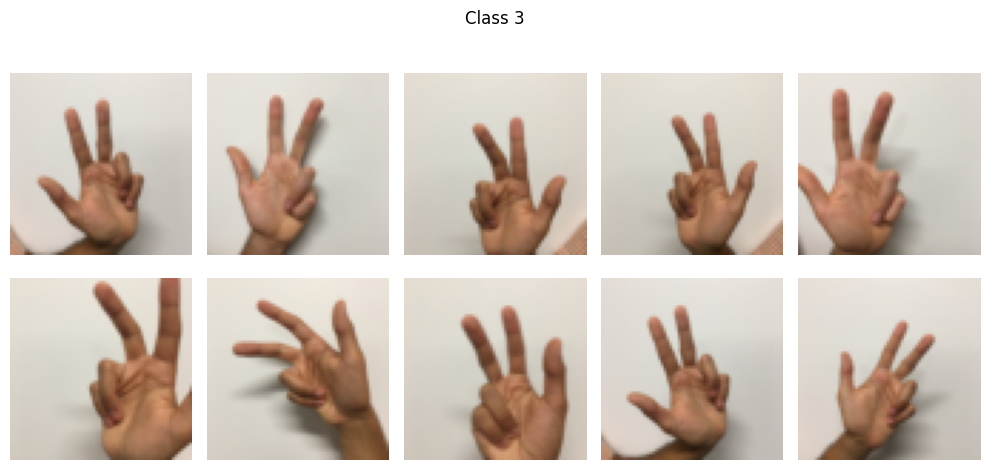

In [98]:
# Plot 10 random hands from the class 3
files = os.listdir(CLASS_3_TRAIN_PATH)
random_files = random.sample(files, 10)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for id, file in enumerate(random_files):
    axs[id//5, id%5].imshow(mpimg.imread(CLASS_3_TRAIN_PATH + file))
    axs[id//5, id%5].axis('off')
plt.suptitle("Class 3")
plt.tight_layout()
plt.show()

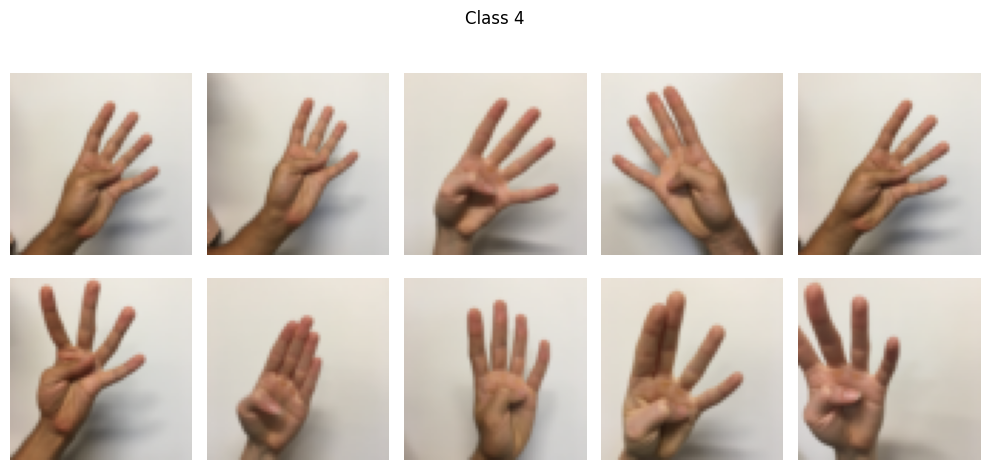

In [99]:
# Plot 10 random hands from the class 4
files = os.listdir(CLASS_4_TRAIN_PATH)
random_files = random.sample(files, 10)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for id, file in enumerate(random_files):
    axs[id//5, id%5].imshow(mpimg.imread(CLASS_4_TRAIN_PATH + file))
    axs[id//5, id%5].axis('off')
plt.suptitle("Class 4")
plt.tight_layout()
plt.show()

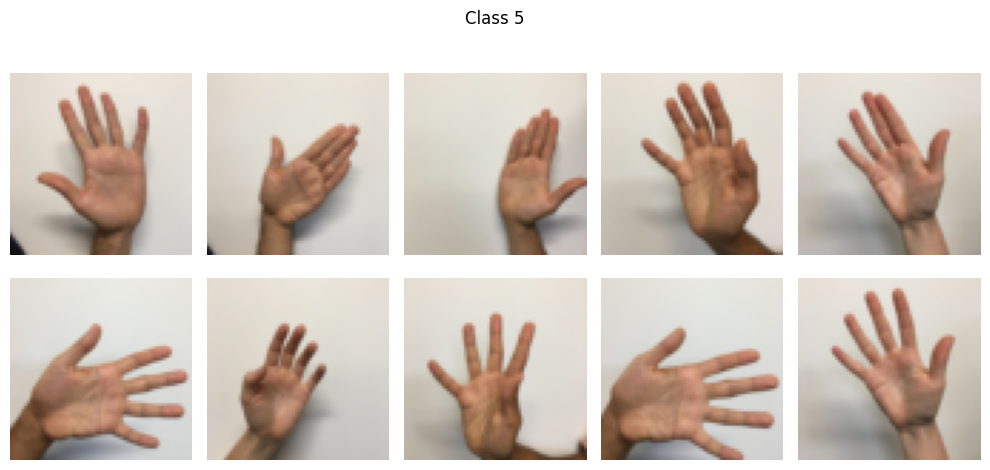

In [100]:
# Plot 10 random hands from the class 5
files = os.listdir(CLASS_5_TRAIN_PATH)
random_files = random.sample(files, 10)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for id, file in enumerate(random_files):
    axs[id//5, id%5].imshow(mpimg.imread(CLASS_5_TRAIN_PATH + file))
    axs[id//5, id%5].axis('off')
plt.suptitle("Class 5")
plt.tight_layout()
plt.show()

### Definimos nuestra clase para las capas convolucionales

In [101]:
class ConvolutionalBlock(nn.Module):
    def __init__(
            self,
            in_channels: int=1,
            out_channels: int=3,
            kernel_size: int=3,
            stride: int=1,
            padding: int=1,
            padding_mode: str='zeros',
            activation=nn.ReLU(),
            pool_kernel_size: int=3,
            pool_stride: int=1,
            pool_padding: int=1
    ):
        super(ConvolutionalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.padding_mode = padding_mode
        self.activation = activation
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding

        # Check parameters consistency
        if kernel_size % 2 == 0:
            assert kernel_size == stride, f"Conv: Stride {stride} must be equal to  even kernel size {kernel_size}."
        else:
            assert ((kernel_size-1) / 2 == padding) & stride == 1, f"Conv: Invalid padding {padding} for the given kernel size {kernel_size}"
        if pool_kernel_size % 2 == 0:
            assert pool_kernel_size == pool_stride, f"Pooling: Stride {pool_stride} must be equal to even kernel size {pool_kernel_size}."
        else:
            assert ((pool_kernel_size-1) / 2 == pool_padding) & pool_stride == 1, f"Pooling: Invalid padding {pool_padding} for the given kernel size {pool_kernel_size}"

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode=padding_mode),
            activation,
            nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding)
        )

    def forward(self, x):
        return self.conv_block(x)

    def getConvOutputShape(self, in_shape):
        return (self.out_channels,
                (in_shape[1] - self.kernel_size + 2*self.padding) // self.stride + 1,
                (in_shape[2] - self.kernel_size + 2*self.padding) // self.stride + 1)

    def getPoolOutputShape(self, in_shape):
        return (self.out_channels,
                (in_shape[1] - self.pool_kernel_size + 2*self.pool_padding) // self.pool_stride + 1,
                (in_shape[2] - self.pool_kernel_size + 2*self.pool_padding) // self.pool_stride + 1)

    def getOutputShape(self, in_shape):
        conv_shape = self.getConvOutputShape(in_shape)
        pool_shape = self.getPoolOutputShape(conv_shape)
        return pool_shape

In [102]:
class CNN(nn.Module):

    def __init__(
            self,
            conv_blocks: list,
            image_shape: tuple=(1, 28, 28),
            n_classes: int=10,
            out_neurons: int=64,
            activation=nn.ReLU(),
            criterion=nn.CrossEntropyLoss(),
            dropout_rate: float=0.5,
            init_type: str='xavier',
            device: str='cpu'
    ):
        super(CNN, self).__init__()
        for conv_block in conv_blocks:
            image_shape = conv_block.getOutputShape(image_shape)
        self.out_shape = image_shape
        self.in_neurons = self.out_shape[0] * self.out_shape[1] * self.out_shape[2]
        self.out_neurons = out_neurons
        self.n_classes = n_classes
        self.activation = activation
        self.criterion = criterion
        self.dropout_rate = dropout_rate
        self.init_type = init_type
        self.device = device

        # Define layers
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.fully_connected = nn.Sequential(
                nn.Linear(self.in_neurons, out_neurons),
                activation,
                nn.Dropout(dropout_rate),
                nn.Linear(out_neurons, n_classes)
        )

        # Initialize the parameters.
        self.initialize_weights(init_type)

        # Define the metrics.
        self.metrics = {
            'epochs': [], 
            'loss': {'train': [], 'eval': []}, 
            'accuracy': {'train': [], 'eval': []}, 
            'time': 0.0
        }

    def initialize_weights(self, init_type):
        for layer in self.fully_connected:
            if isinstance(layer, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                elif init_type == 'he':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                else:
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                if layer.bias is not None:
                    nn.init.uniform_(layer.bias, a=0, b=1)

    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = x.view(-1, self.in_neurons)
        return self.fully_connected(x)
    
    def trainBatch(self, inputs_batch, targets_batch, optimizer):
        inputs_batch = inputs_batch.to(self.device)             # push inputs to GPU
        targets_batch = targets_batch.to(self.device)           # push labels to GPU
        predictions_batch = self.forward(inputs_batch)          # forward pass
        loss = self.criterion(predictions_batch, targets_batch) # compute the training loss
        optimizer.zero_grad()                                   # zero the gradients
        loss.backward()                                         # backward pass
        optimizer.step()                                        # update the parameters (weights and biases)
        return loss.item()

    def predict(self, inputs):
        predictions = self.forward(inputs)
        _, predictions = torch.max(predictions.data, 1)
        return predictions

    def computeLoss(self, dataloader):
        loss = 0.0
        samples = 0
        self.eval() # set the model to evaluation mode
        for inputs_batch, targets_batch in dataloader:
            with torch.no_grad():
                inputs_batch = inputs_batch.to(self.device)                             # push inputs to GPU
                targets_batch = targets_batch.to(self.device)                           # push labels to GPU
                predictions_batch = self.forward(inputs_batch)                          # forward pass
                batch_loss = self.criterion(predictions_batch, targets_batch).item()    # compute the loss
                loss += batch_loss * inputs_batch.size(0)                               # accumulate the weighted loss
                samples += inputs_batch.size(0)                                         # accumulate the number of samples
        return loss / samples
    
    def computeAccuracy(self, dataloader):
        self.eval() # set the model to evaluation mode
        accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=self.n_classes).to(self.device)
        for inputs_batch, targets_batch in dataloader:
            inputs_batch = inputs_batch.to(self.device)         # push inputs to GPU
            targets_batch = targets_batch.to(self.device)       # push labels to GPU
            predictions_batch = self.forward(inputs_batch)      # forward pass
            accuracy.update(predictions_batch, targets_batch)
        return accuracy.compute().item()
    
    def fit(self, train_dataloader, optimizer=optim.Adam, epochs=30, lr=1e-4, 
        regularization=0.0, eval_dataloader=None, verbose=True, epch_print=1, 
        tolerance=1e-3, patience=5):

        # Set the starting epoch
        last_epoch = self.metrics['epochs'][-1] if self.metrics['epochs'] else 0
        starting_epoch = last_epoch + 1
    
        # Set the optimizer
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=regularization)

        # Variables for early stopping
        error_loss, error_accuracy = 1, 1
        old_loss, old_accuracy = None, None
        epochs_since_improvement = 0

        # Start the training
        start_time = time.time()
        for i in range(epochs):
            self.train()
            for train_batch in train_dataloader:
                self.trainBatch(train_batch[0], train_batch[1], optimizer)

            # Evaluate the model
            self.eval()
            train_loss = self.computeLoss(train_dataloader)
            train_acc = self.computeAccuracy(train_dataloader)
            self.metrics['epochs'].append(starting_epoch + i)
            self.metrics['loss']['train'].append(train_loss)
            self.metrics['accuracy']['train'].append(train_acc)
            if eval_dataloader:
                eval_loss = self.computeLoss(eval_dataloader)
                eval_acc = self.computeAccuracy(eval_dataloader)
                self.metrics['loss']['eval'].append(eval_loss)
                self.metrics['accuracy']['eval'].append(eval_acc)

                # Check early stopping conditions on eval set
                if i == 0:
                    old_loss, old_accuracy = eval_loss, eval_acc
                else:
                    error_loss = abs(eval_loss - old_loss) / old_loss
                    error_accuracy = abs(eval_acc - old_accuracy) / old_accuracy
                    old_loss, old_accuracy = eval_loss, eval_acc
            else:
                # Check early stopping conditions on train set
                if i == 0:
                    old_loss, old_accuracy = train_loss, train_acc
                else:
                    error_loss = abs(train_loss - old_loss) / old_loss
                    error_accuracy = abs(train_acc - old_accuracy) / old_accuracy
                    old_loss, old_accuracy = train_loss, train_acc
            
            if (error_loss <= tolerance) and (error_accuracy <= tolerance):
                epochs_since_improvement += 1
            else:
                epochs_since_improvement = 0
            
            # Print the progress
            if verbose and (i + 1) % epch_print == 0:
                eval_loss = eval_loss if eval_dataloader else 'N/A'
                text = f"Epoch {starting_epoch + i}/{starting_epoch + epochs}: "
                text += f"Loss ({train_loss:.4g}, {eval_loss:.4g}) \t "
                text += f"Accuracy ({100*train_acc:.2f}%, {100*eval_acc:.2f}%)"
                print(text)

            # Early stopping check
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {i + 1} epochs.")
                break

        self.metrics['time'] += time.time() - start_time

    def size(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def save(self, path: str="cnn_model_params.pth"):
        torch.save(self.state_dict(), path)

    def load(self, path: str="cnn_model_params.pth"):
        self.load_state_dict(torch.load(path))
        self.to(self.device)

### Definimos nuestra arquitectura de red neuronal

En la siguiente celda se define una clase para una red neuronal convolucional con 4 capas convolucionales, cada una seguida de un max pooling. Luego del último bloque convolucional-pooling se realiza un flatten y se agregan 2 capas densas para la clasificación.

Para que esta celda funcione se debe completar el valor de `in_features` de la primera capa densa, el cual se puede calcular sabiendo el tamaño de las imágenes de entrada a la red, y cómo afecta cada capa convolucional y de pooling a las dimensión del tensor de entrada de dicha capa densa.

In [103]:
num_classes = 6
classes_names = ["0", "1", "2", "3", "4", "5"]
width, height = 64, 64

In [104]:
parameters = {
        'conv_layers': [
            {
                'in_channels': 3,
                'out_channels': 16,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 16,
                'out_channels': 32,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 32,
                'out_channels': 64,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 64,
                'out_channels': 128,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            }
        ],
        'full_layers': [512],
        'n_classes': num_classes,
        'dropout_rate': 0.2,
        'activation': nn.ReLU(),
        'criterion': nn.CrossEntropyLoss(),
        'init_type': 'xavier',
        'device': device
    }

### 1) Entrenar sin aplicar Data Augmentation

En primer lugar se define una composición de transformaciones que no realice ninguna modificación sobre las imágenes más que pasarlas a tensores, como lo pide torchvision. Luego se definen los `DataLoaders` para el entrenamiento.

In [105]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])

train_set = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transforms)
valid_set = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=8, shuffle=True)

In [112]:
# Build the model
conv_blocks = []
for conv_layer in parameters['conv_layers']:
    conv_block = ConvolutionalBlock(**conv_layer)
    conv_blocks.append(conv_block)
model = CNN(conv_blocks=conv_blocks, 
            image_shape=(3, width, height),
            n_classes=parameters['n_classes'],
            out_neurons=parameters['full_layers'][0],
            activation=parameters['activation'], 
            criterion=parameters['criterion'], 
            dropout_rate=parameters['dropout_rate'],
            init_type=parameters['init_type'],
            device=parameters['device'])
model = model.to(model.device)

# Temporarily move model to CPU for the summary
model_cpu = model.to("cpu")
torchsummary.summary(model_cpu, (3, width, height), device="cpu")

# Move the model back to MPS after summary (if MPS was available)
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
              ReLU-3           [-1, 16, 64, 64]               0
              ReLU-4           [-1, 16, 64, 64]               0
              ReLU-5           [-1, 16, 64, 64]               0
              ReLU-6           [-1, 16, 64, 64]               0
              ReLU-7           [-1, 16, 64, 64]               0
              ReLU-8           [-1, 16, 64, 64]               0
              ReLU-9           [-1, 16, 64, 64]               0
        MaxPool2d-10           [-1, 16, 32, 32]               0
ConvolutionalBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           4,640
             ReLU-13           [-1, 32, 32, 32]               0
             ReLU-14           [-1, 32

Realizar el entrenamiento de la red durante 30 épocas y observar el sobreentrenamiento que se genera en el modelo.

In [113]:
# Define fit parameters.
optimizer = optim.Adam
epochs = 50
lr = 1e-3
verbose = True
epch_print = 20
tolerance = 1e-3
patience = 10

In [114]:
model.fit(train_loader, optimizer=optimizer, epochs=epochs, lr=lr, 
          eval_dataloader=valid_loader, verbose=verbose, epch_print=epch_print, 
          tolerance=tolerance, patience=patience)
model.save("hands.pth")

Epoch 20/51: Loss (0.7221, 1.164) 	 Accuracy (71.67%, 55.83%)
Epoch 40/51: Loss (0.0007747, 2.162) 	 Accuracy (100.00%, 67.50%)


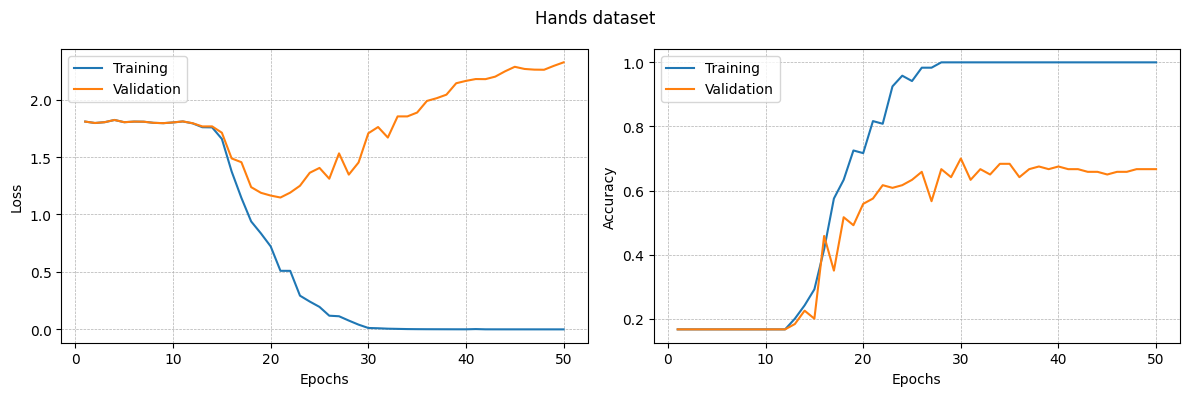

In [115]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(model.metrics['epochs'], model.metrics['loss']['train'], label=f"Training")
axs[0].plot(model.metrics['epochs'], model.metrics['loss']['eval'], label=f"Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='best')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].set_xticks(np.arange(0, len(model.metrics['epochs'])+1, 10, dtype=int))

# Plot accuracy
axs[1].plot(model.metrics['epochs'], model.metrics['accuracy']['train'], label=f"Training")
axs[1].plot(model.metrics['epochs'], model.metrics['accuracy']['eval'], label=f"Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(loc='best')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].set_xticks(np.arange(0, len(model.metrics['epochs'])+1, 10, dtype=int))

plt.suptitle("Hands dataset")
plt.tight_layout()
plt.savefig("hands_results.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

---
### 2) Entrenar aplicando Data Augmentation

A continuación se define una composición de transformaciones para aplicar data augmentation sobre el conjunto de entrenamiento.

Ejecutar la celda para entrenar durante, al menos, 100 épocas y analizar los resultados.

In [116]:
aug_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(64, 64), scale=(0.2, 0.7)),
    torchvision.transforms.RandomRotation(degrees=90),
    torchvision.transforms.RandomPerspective(0.8),
    torchvision.transforms.RandomGrayscale(0.5),
    torchvision.transforms.ToTensor(),
    ])

aug_train_set = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=aug_transforms)
aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=8, shuffle=True)

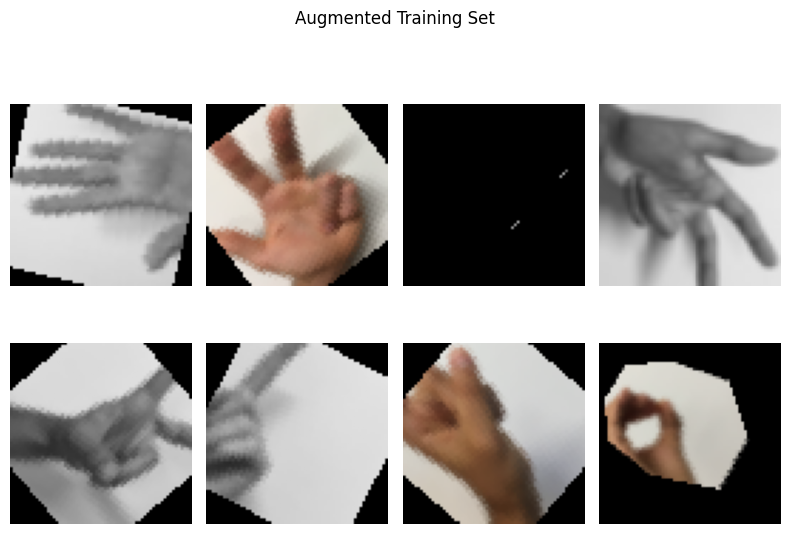

In [118]:
# take 1 batch from the augmented training set and plot 20 random images
aug_train_batch = next(iter(aug_train_loader))
fig, axs = plt.subplots(2, 4, figsize=(8, 6))
for i in range(8):
    axs[i//4, i%4].imshow(aug_train_batch[0][i].permute(1, 2, 0).cpu().numpy())
    axs[i//4, i%4].axis('off')
plt.suptitle("Augmented Training Set")
plt.tight_layout()
plt.show()

In [119]:
# Build the model
conv_blocks = []
for conv_layer in parameters['conv_layers']:
    conv_block = ConvolutionalBlock(**conv_layer)
    conv_blocks.append(conv_block)
model_aug = CNN(conv_blocks=conv_blocks, 
                image_shape=(3, width, height),
                n_classes=parameters['n_classes'],
                out_neurons=parameters['full_layers'][0],
                activation=parameters['activation'], 
                criterion=parameters['criterion'], 
                dropout_rate=parameters['dropout_rate'],
                init_type=parameters['init_type'],
                device=parameters['device'])
model_aug = model_aug.to(model_aug.device)

# Temporarily move model to CPU for the summary
model_cpu = model_aug.to("cpu")
torchsummary.summary(model_cpu, (3, width, height), device="cpu")

# Move the model back to MPS after summary (if MPS was available)
model_aug = model_aug.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
              ReLU-3           [-1, 16, 64, 64]               0
              ReLU-4           [-1, 16, 64, 64]               0
              ReLU-5           [-1, 16, 64, 64]               0
              ReLU-6           [-1, 16, 64, 64]               0
              ReLU-7           [-1, 16, 64, 64]               0
              ReLU-8           [-1, 16, 64, 64]               0
              ReLU-9           [-1, 16, 64, 64]               0
        MaxPool2d-10           [-1, 16, 32, 32]               0
ConvolutionalBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           4,640
             ReLU-13           [-1, 32, 32, 32]               0
             ReLU-14           [-1, 32

In [120]:
# Define fit parameters.
optimizer = optim.Adam
epochs = 100
lr = 1e-4
verbose = True
epch_print = 20
tolerance = 1e-3
patience = 10

In [121]:
model_aug.fit(aug_train_loader, optimizer=optimizer, epochs=epochs, lr=lr, 
              eval_dataloader=valid_loader, verbose=verbose, epch_print=epch_print, 
              tolerance=tolerance, patience=patience)
model_aug.save("hands_aug.pth")

Epoch 20/101: Loss (1.793, 1.795) 	 Accuracy (16.67%, 16.67%)
Epoch 40/101: Loss (1.792, 1.786) 	 Accuracy (18.33%, 25.00%)
Epoch 60/101: Loss (1.788, 1.774) 	 Accuracy (20.00%, 22.50%)
Epoch 80/101: Loss (1.783, 1.756) 	 Accuracy (21.67%, 18.33%)
Epoch 100/101: Loss (1.779, 1.732) 	 Accuracy (20.00%, 24.17%)


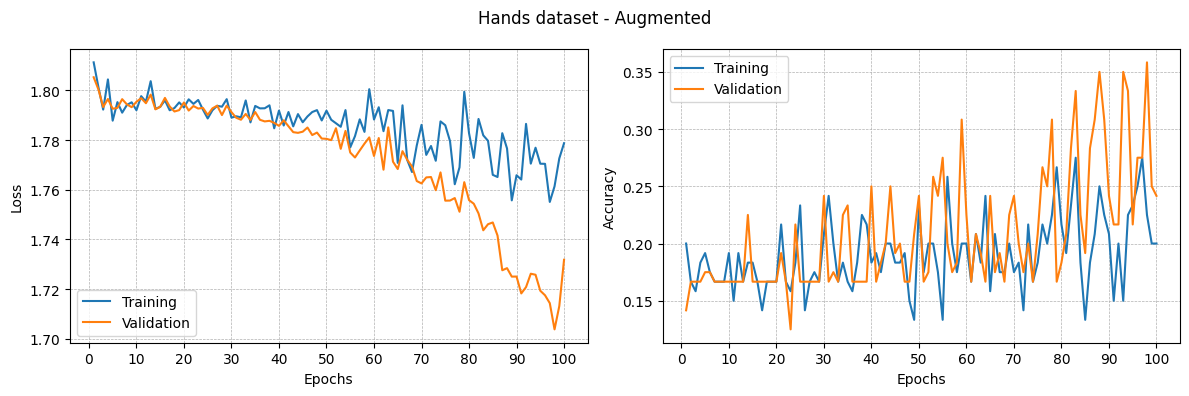

In [122]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(model_aug.metrics['epochs'], model_aug.metrics['loss']['train'], label=f"Training")
axs[0].plot(model_aug.metrics['epochs'], model_aug.metrics['loss']['eval'], label=f"Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='best')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].set_xticks(np.arange(0, len(model_aug.metrics['epochs'])+1, 10, dtype=int))

# Plot accuracy
axs[1].plot(model_aug.metrics['epochs'], model_aug.metrics['accuracy']['train'], label=f"Training")
axs[1].plot(model_aug.metrics['epochs'], model_aug.metrics['accuracy']['eval'], label=f"Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(loc='best')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].set_xticks(np.arange(0, len(model_aug.metrics['epochs'])+1, 10, dtype=int))

plt.suptitle("Hands dataset - Augmented")
plt.tight_layout()
plt.savefig("hands_aug_results.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

###**Algunas preguntas para analizar**

1) ¿Es el resultado del entrenamiento aceptable?

2) ¿Está el Data Augmentation mejorando o empeorando el resultado?

3) Basándose en las características de las imágenes del conjunto de validación, diría que el tipo de transformaciones utilizadas es acertado? (Se puede usar la celda del principio del Colab para visualizar imágenes del conjunto de validación)

4) Basándose en los resultados del entrenamiento, diría que los parámetros de las transformaciones aplicadas tienen valores agresivos? (Se puede utilizar la celda siguiente para visualizar un conjunto de imágenes y sus versiones transformadas)

### 3) Mejorar/corregir el Data Augmentation

En base a su criterio y a las reflexiones de las preguntas anteriores, defina una nueva composición de transformaciones que ayude a obtener buenos resultados sobre el entrenamiento. Intentar obtener métricas que superen el 90% de accuracy sin caer en sobreentrenamiento. Incrementar la cantidad de épocas de entrenamiento si es necesario.

In [123]:
new_aug_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomRotation(degrees=90),
    torchvision.transforms.RandomAutocontrast(0.5),
    torchvision.transforms.ToTensor(),
    ])

new_aug_train_set = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=new_aug_transforms)
new_aug_train_loader = torch.utils.data.DataLoader(new_aug_train_set, batch_size=8, shuffle=True)

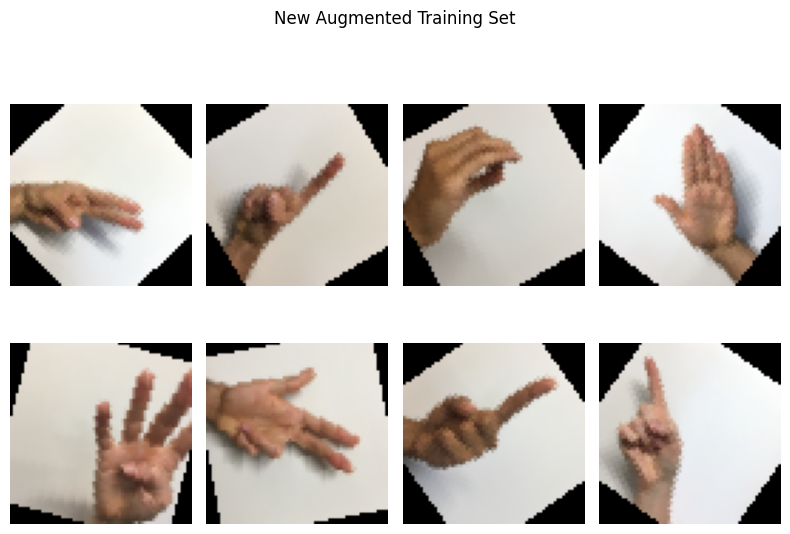

In [124]:
# take 1 batch from the augmented training set and plot 20 random images
new_aug_train_batch = next(iter(new_aug_train_loader))
fig, axs = plt.subplots(2, 4, figsize=(8, 6))
for i in range(8):
    axs[i//4, i%4].imshow(new_aug_train_batch[0][i].permute(1, 2, 0).cpu().numpy())
    axs[i//4, i%4].axis('off')
plt.suptitle("New Augmented Training Set")
plt.tight_layout()
plt.show()

In [125]:
# Build the model
conv_blocks = []
for conv_layer in parameters['conv_layers']:
    conv_block = ConvolutionalBlock(**conv_layer)
    conv_blocks.append(conv_block)
model_new_aug = CNN(conv_blocks=conv_blocks, 
                    image_shape=(3, width, height),
                    n_classes=parameters['n_classes'],
                    out_neurons=parameters['full_layers'][0],
                    activation=parameters['activation'], 
                    criterion=parameters['criterion'], 
                    dropout_rate=parameters['dropout_rate'],
                    init_type=parameters['init_type'],
                    device=parameters['device'])
model_new_aug = model_new_aug.to(model_new_aug.device)

# Temporarily move model to CPU for the summary
model_cpu = model_new_aug.to("cpu")
torchsummary.summary(model_cpu, (3, width, height), device="cpu")

# Move the model back to MPS after summary (if MPS was available)
model_new_aug = model_new_aug.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
              ReLU-3           [-1, 16, 64, 64]               0
              ReLU-4           [-1, 16, 64, 64]               0
              ReLU-5           [-1, 16, 64, 64]               0
              ReLU-6           [-1, 16, 64, 64]               0
              ReLU-7           [-1, 16, 64, 64]               0
              ReLU-8           [-1, 16, 64, 64]               0
              ReLU-9           [-1, 16, 64, 64]               0
        MaxPool2d-10           [-1, 16, 32, 32]               0
ConvolutionalBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           4,640
             ReLU-13           [-1, 32, 32, 32]               0
             ReLU-14           [-1, 32

In [126]:
# Define fit parameters.
optimizer = optim.Adam
epochs = 500
lr = 1e-4
verbose = True
epch_print = 50
tolerance = 1e-3
patience = 10

In [127]:
model_new_aug.fit(new_aug_train_loader, optimizer=optimizer, epochs=epochs, lr=lr, 
                  eval_dataloader=valid_loader, verbose=verbose, epch_print=epch_print, 
                  tolerance=tolerance, patience=patience)
model_new_aug.save("hands_new_aug.pth")

Epoch 50/501: Loss (1.266, 1.269) 	 Accuracy (52.50%, 50.00%)
Epoch 100/501: Loss (0.8283, 0.8327) 	 Accuracy (70.00%, 75.00%)
Epoch 150/501: Loss (0.4901, 0.5243) 	 Accuracy (86.67%, 82.50%)
Epoch 200/501: Loss (0.2959, 0.391) 	 Accuracy (86.67%, 85.83%)
Epoch 250/501: Loss (0.3453, 0.4819) 	 Accuracy (87.50%, 80.83%)
Epoch 300/501: Loss (0.1329, 0.2191) 	 Accuracy (95.00%, 93.33%)
Epoch 350/501: Loss (0.1233, 0.2567) 	 Accuracy (96.67%, 90.00%)
Epoch 400/501: Loss (0.169, 0.2529) 	 Accuracy (96.67%, 91.67%)
Epoch 450/501: Loss (0.04734, 0.1801) 	 Accuracy (98.33%, 95.83%)
Epoch 500/501: Loss (0.02372, 0.1853) 	 Accuracy (99.17%, 94.17%)


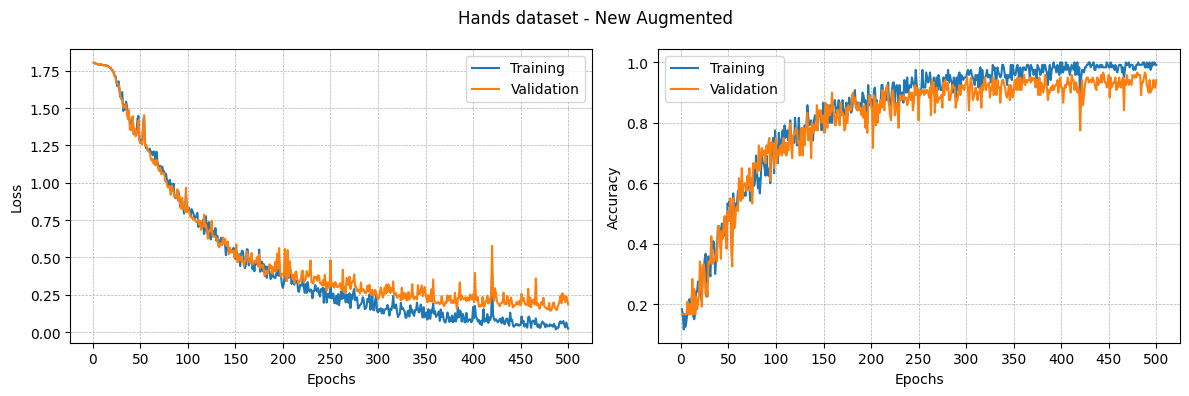

In [128]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(model_new_aug.metrics['epochs'], model_new_aug.metrics['loss']['train'], label=f"Training")
axs[0].plot(model_new_aug.metrics['epochs'], model_new_aug.metrics['loss']['eval'], label=f"Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='best')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].set_xticks(np.arange(0, len(model_new_aug.metrics['epochs'])+1, 50, dtype=int))

# Plot accuracy
axs[1].plot(model_new_aug.metrics['epochs'], model_new_aug.metrics['accuracy']['train'], label=f"Training")
axs[1].plot(model_new_aug.metrics['epochs'], model_new_aug.metrics['accuracy']['eval'], label=f"Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(loc='best')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].set_xticks(np.arange(0, len(model_new_aug.metrics['epochs'])+1, 50, dtype=int))

plt.suptitle("Hands dataset - New Augmented")
plt.tight_layout()
plt.savefig("hands_new_aug_results.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

### Conclusiones

- Que tipo de transformaciones son mas efectivas en este dataset?
